<a href="https://colab.research.google.com/github/Pro100v/PythonProjects/blob/master/PythonProjects/DataAnalysis/TestTasks/Yandex/ya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Вопрос 1

Имеется файл https://yadi.sk/i/IxBCaRP83Kz8dj с временной статистикой работы асессоров над однотипным заданием.

Формат файла: login tid Microtasks assigned_ts tclosed_ts. Пояснение к формату: 
- **login** — логин асессора; 
- **tid** — id оцениваемого задания (task id); 
- **Microtasks** – количество микрозаданий в одном задании; 
- **assigned_ts** — время резервирования системой задания для асессора; 
- **closed_ts** — точное время завершения работы над заданием; разделитель — табуляция \t.

Задание может состоять из одного или несколько микрозаданий. Время резервирования задания (assigned_ts) указывает на тот момент, когда система назначила определенного асессора исполнителем этого задания. Этот момент может совпадать с временем начала работы асессора над заданием, а может и не совпадать (асессор может отойти выпить чаю, а потом приступить к заданию, асессор может выполнять предыдущее задание, в то время как за ним зарезервированы новые).

Предположим, что асессор за 30 секунд своего рабочего времени получает N рублей.

Какую оплату вы считаете справедливой для выполнения асессором одного микрозадания из этого файла? Опишите подробно все этапы вашего решения.

### Проработка: 

#### Идея
- рассчитать среднее значение времени на выполнение одной микрозадачи 
- исходя из полученного на предыдущем шаге среднего значения, рассчитать количество микрозадач, которые может выполнить асессор в режиме работы 5/8. В расчетах использовать допущение, что асессор на выполнение работы тратит 80% от всего рабочего времени. 
- в качестве допущения, взять среднюю заработную плату в размере **30 0000 рублей** и разделить ее на количество микрозадач, которые может выполняит асессор в месяц
- получим стоимсть выполнения одной микрозадачи. **done**

#### Работа с данными
1. Определить и удалить ложные данные в датасете
2. Посмотреть наличие выбросов и попытаться их устранить, для работы с более значимыми данными

#### Рассчеты
1. Высчитать время выполнения всего задания. **Цель:** возможность для среднего времени выполнения одной микрозадачи.**
2. Посчитать среднее время на выполнение одной микрозадачи. **Цель:** для оперирования в последующих расчетах средним временем на выполнения микрозадачи и в последствии выйти на приемлемую оплату
3. (~) Определить сколько временных слотов по 30 сек. требуется для выполнения одной микрозадачи. **Цель:** получение коэфициента стоимости работ асессора за выполнения средней велечины выполнения одной микрозадачи, исходя из тарифа в N рублей за 30 секунд.
4. Рассчитать медианный показатель (медиана сгладит негативный эффект "грязного" времени выполнения микрозадачи) выполнения одной микрозадачи, сгруппированных по месяцам. Цель: получить 


In [2]:
import pandas as pd
from datetime import datetime, timedelta
import requests
from urllib.parse import urlencode
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://yadi.sk/i/IxBCaRP83Kz8dj'  # Сюда вписываете вашу ссылку

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
download_url

'https://downloader.disk.yandex.ru/disk/cf138504073b53efa02918b3a53345033da2c6a73d7f52abbe691c1b548947e0/5f7ba357/bu92kZqLm5Gkr9yvLBQQ4I6AHYj-Ltsyp_feXYifhcw0wSq6PtNoJYAMAIdyZalbSUFzq3USfP7D_1XF6bRulA%3D%3D?uid=0&filename=data_task4_old.txt&disposition=attachment&hash=TKpkeqTtSkR3GS3SLe56%2BbV1Ms0cpBwIePhPjMDAMi4%3D%3A&limit=0&content_type=text%2Fplain&owner_uid=45647354&fsize=45540847&hid=1a360c0e2a08dceec4f4a4c225706cd9&media_type=document&tknv=v2'

In [4]:
file = download_url
df = pd.read_csv(download_url, sep='\t', nrows=None, parse_dates=['assigned_ts', 'closed_ts'], dayfirst=False)
df.head()

,login,tid,Microtasks,assigned_ts,closed_ts
0,login0,190563850.0,4.0,2017-04-20 12:09:39,2017-04-20 13:13:01
1,login0,190561754.0,1.0,2017-04-20 12:10:30,2017-04-20 12:28:29
2,login0,190565906.0,4.0,2017-04-20 12:21:31,2017-04-20 13:30:10
3,login0,190560246.0,1.0,2017-04-20 12:28:30,2017-04-20 13:13:56
4,login0,190562168.0,2.0,2017-04-20 12:28:42,2017-04-20 13:14:50


In [5]:
# определение ложных даннах

# поиск записей дата назначения задачи больше чем ее дата завепшения
indxr = df[df.assigned_ts	>= df.closed_ts]
indxr

,login,tid,Microtasks,assigned_ts,closed_ts
534453,login585,197340894.0,1.0,2017-05-24 16:13:06,2017-05-24 16:00:57


In [6]:
# удаление "ложных" данных
df.drop(indxr.index, inplace=True)

In [7]:
# Рассчитаем время на выполнение задачи в секундах
df['tm_delta_seconds'] = (df.closed_ts - df.assigned_ts) / timedelta(seconds=1)

In [8]:
# вычислим время выполнения одной микрозадачи в секундах
df['avg_tm_microtask_complete'] = df.tm_delta_seconds / df.Microtasks

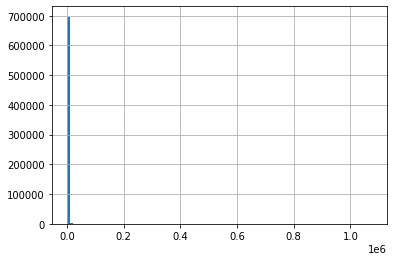

In [70]:
# посмотрим распределение полученных величин на гистограмме
df.avg_tm_microtask_complete.hist(bins=100)

In [62]:
df.avg_tm_microtask_complete.describe()

count    7.018260e+05
mean     5.681534e+02
std      5.378999e+03
min      1.769231e+00
25%      3.700000e+01
50%      7.500000e+01
75%      1.820000e+02
max      1.074156e+06
Name: avg_tm_microtask_complete, dtype: float64

максимальное значение в данных на выполнение одной микрозадачи составляет *1 074 156 секунд* или более *12 дней*, что явно является выбросом в данных - который может негатино отразиться на дальнейших рассчетах. Постараемся очистить данные по [правилу 3 сигм](https://ru.wikipedia.org/wiki/%D0%A1%D1%80%D0%B5%D0%B4%D0%BD%D0%B5%D0%BA%D0%B2%D0%B0%D0%B4%D1%80%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%BE%D1%82%D0%BA%D0%BB%D0%BE%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5#%D0%9F%D1%80%D0%B0%D0%B2%D0%B8%D0%BB%D0%BE_%D1%82%D1%80%D1%91%D1%85_%D1%81%D0%B8%D0%B3%D0%BC)



In [67]:
1.074156e+06 / 60 / 60 / 24

12.432361111111112

In [68]:
# высчитаем отклонение от среднего
dev = (df.avg_tm_microtask_complete - df.avg_tm_microtask_complete.mean()).abs()
# высчитаем среднее отклонение 
std = df.avg_tm_microtask_complete.std()
# применим правило 3 сиги и полученный результат запишем в новый нобор данных
df_trimmed = df[~(dev > std*3)]
df_trimmed.avg_tm_microtask_complete.describe()

count    698602.000000
mean        362.049276
std        1217.537366
min           1.769231
25%          37.000000
50%          74.000000
75%         178.888889
max       16704.000000
Name: avg_tm_microtask_complete, dtype: float64

In [66]:
16704 / 60 / 60 / 1

4.64

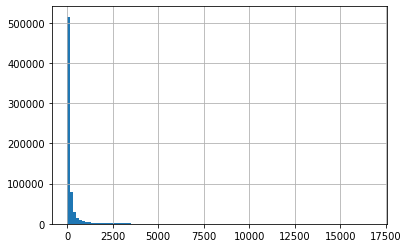

In [69]:
df_trimmed.avg_tm_microtask_complete.hist(bins=100)

в очишенном наборе данных уже нет сильных выбросов, при том кол-во данных сократилось не значительно с 701'826 записей до 698'602. Максимальное время выполнения одно микрозадачи составляет 16704 секунд, или около 4,5 часа - что больше похоже на правду.

In [78]:
# сгруппируем данные по месяцам и асессорам и расчитаем для полученных записей
# медианное значение среднего времени выполнения микрозадачи в секундах
# т.о. получим среднее время выполнения одной микрозадачи по ассесорам в рамках 
# месяца (медиана сгладит ситуацию с "грязным временем" выполнения микрозадачи)

df_month_login = df_trimmed.groupby(by=[df_trimmed.assigned_ts.dt.month_name(), df_trimmed.login])\
    ['avg_tm_microtask_complete'].median()\
    .reset_index()
df_month_login[5:-5]

,assigned_ts,login,avg_tm_microtask_complete
5,April,login103,136.000000
6,April,login105,44.472222
7,April,login106,54.000000
8,April,login108,99.100000
9,April,login109,983.000000
...,...,...,...
1687,May,login90,91.000000
1688,May,login91,44.000000
1689,May,login92,114.500000
1690,May,login93,114.000000


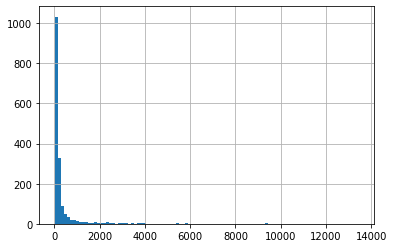

In [79]:
# посмотрим распределение полученных величин на гистограмме
df_month_login.avg_tm_microtask_complete.hist(bins=100)

In [80]:
df_month_login.describe()

,avg_tm_microtask_complete
count,1697.000000
mean,345.234824
std,885.831228
min,14.666667
25%,68.500000
50%,115.000000
75%,229.500000
max,13447.000000


In [81]:
# запомним медианное значение времени выполнения одной микрозадачи в секундах
median_tm_cmplt_microtask = round(df_month_login.avg_tm_microtask_complete.median())
print(f"Среднее время выполнения 1 микрозадачи: {median_tm_cmplt_microtask} сек.")

Среднее время выполнения 1 микрозадачи: 115 сек.


In [82]:
wh_year_all = 1979  # количество рабочих часов в 2020 году по данным производственного каллендаря 
wh_year_eff = wh_year_all * .8 # 80% эффективного времени от общего значения
wh_month_eff = wh_year_eff / 12 # кол-во эффективных часов в месяц
microtasks_per_month = (wh_month_eff * 60 * 60) / median_tm_cmplt_microtask
print(f"Объем микрозадач в месяц на 1 асессора: {round(microtasks_per_month)} шт.")


Объем микрозадач в месяц на 1 асессора: 4130 шт.


In [83]:
# Средняя зарплата в России в 2020 году по данным Росстата
# средняя зарплата в России по состоянию на январь 2020 года составила 46674 руб.
avg_salary = 46674

tax_per_microtask = round(avg_salary / microtasks_per_month)
print(f"Стоимость одной микрозадачи: {tax_per_microtask} рублей")

Стоимость одной микрозадачи: 11 рублей


In [92]:
df_tmp = (df_trimmed.groupby(by=[df_trimmed.assigned_ts.dt.month_name(), df_trimmed.login])['Microtasks'].sum()*tax_per_microtask).reset_index()

In [105]:
# df_tmp[df_tmp.Microtasks > 100000]
# df[df.login.eq('login652')]\
#   .groupby(df.assigned_ts.dt.month_name())\
#   .agg({'tid':'count', 'Microtasks':'sum'})\
#   .assign(total_sallary= lambda x: x['Microtasks']*tax_per_microtask)

,tid,Microtasks,total_sallary
assigned_ts,,,
April,1616,6684.0,73524.0
May,6528,35368.0,389048.0


In [106]:
df_tmp.head()

,assigned_ts,login,Microtasks
0,April,login0,7590.0
1,April,login10,726.0
2,April,login100,22.0
3,April,login101,27115.0
4,April,login102,693.0
